In [ ]:
#구글 드라이브 연결하기
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
#필요한 모듈
import torch
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [ ]:
# pandas를 이용하여 파일 불러오기
train = pd.read_csv("/content/gdrive/MyDrive/ml-100k/ua.base",
                    sep="\t", names=["user","movie","rating","timestamp"])
test = pd.read_csv("/content/gdrive/MyDrive/ml-100k/ua.test",
                   sep="\t", names=["user", "movie", "rating", "timestamp"])

In [ ]:
# 파일 불러오기
# pytorch tensor데이터로 변환
items = torch.tensor(train['movie'], dtype=torch.long)
users = torch.tensor(train['user'], dtype=torch.long)
ratings = torch.tensor(train['rating'], dtype=torch.float)

items_test = torch.tensor(test['movie'], dtype=torch.long)
users_test = torch.tensor(test['user'], dtype=torch.long)
ratings_test = torch.tensor(test['rating'], dtype=torch.float)

In [ ]:
rank = 10 #사용자vector, 아이템 vector의 차원
numUsers = users.max() + 1 #사용자수
numItems = items.max() + 1 #아이템수

P = torch.randn(numItems,rank,requires_grad=True) #아이템 매트릭스
Q = torch.randn(numUsers,rank,requires_grad=True) #사용자 매트릭스

In [ ]:
#Matrix Factorization
optimizer = torch.optim.Adam([P,Q], lr=0.1)

X = []
Y = []
Y_test = []

for epoch in range(1001):
  hypothesis = (P[items]*Q[users]).sum(dim=1)
  cost = F.mse_loss(hypothesis, ratings)

  optimizer.zero_grad()
  cost.backward()
  optimizer.step()

  with torch.no_grad():
    X.append(epoch)
    Y.append(cost.item())

    hypo_test = (P[items_test] * Q[users_test]).sum(dim=1)
    cost_test = F.mse_loss(hypo_test,ratings_test)
    
    Y_test.append(cost_test)

    if epoch % 100 == 0:
      print(f"epoch: {epoch}, cost: {cost.item()}")

epoch: 0, cost: 23.6146240234375
epoch: 100, cost: 0.55482417345047
epoch: 200, cost: 0.4888986051082611
epoch: 300, cost: 0.46891558170318604
epoch: 400, cost: 0.4593854248523712
epoch: 500, cost: 0.45368850231170654
epoch: 600, cost: 0.45008939504623413
epoch: 700, cost: 0.4477338492870331
epoch: 800, cost: 0.446013867855072
epoch: 900, cost: 0.44468143582344055
epoch: 1000, cost: 0.4435909390449524


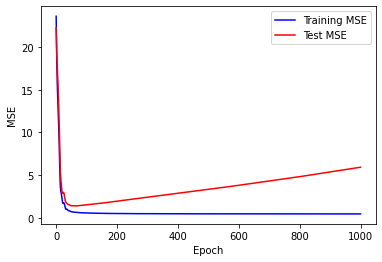

In [ ]:
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.plot(X,Y, c="blue", label="Training MSE")
plt.plot(X,Y_test, c="red", label="Test MSE")

plt.legend()
plt.show()

In [ ]:
#Regularization 추가하기

P = torch.randn(numItems,rank,requires_grad=True) #아이템 매트릭스
Q = torch.randn(numUsers,rank,requires_grad=True) #사용자 매트릭스

lambda1 = 0.0001
lambda2 = 0.0001

optimizer = torch.optim.Adam([P,Q], lr=0.1)

X = []
Y = []
Y_test = []

for epoch in range(1001):
  hypothesis = (P[items]*Q[users]).sum(dim=1)
  cost = F.mse_loss(hypothesis, ratings)
  loss = cost + lambda1 * torch.sum(P**2) + lambda2 * torch.sum(Q**2)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  with torch.no_grad():
    X.append(epoch)
    Y.append(cost.item())

    hypo_test = (P[items_test] * Q[users_test]).sum(dim=1)
    cost_test = F.mse_loss(hypo_test,ratings_test)
    
    Y_test.append(cost_test)

    if epoch % 100 == 0:
      print(f"epoch: {epoch}, cost: {cost.item()}")

epoch: 0, cost: 23.323457717895508
epoch: 100, cost: 0.6885824799537659
epoch: 200, cost: 0.6420742273330688
epoch: 300, cost: 0.632244884967804
epoch: 400, cost: 0.6292194128036499
epoch: 500, cost: 0.627800464630127
epoch: 600, cost: 0.6269636750221252
epoch: 700, cost: 0.6264499425888062
epoch: 800, cost: 0.6261818408966064
epoch: 900, cost: 0.6260555386543274
epoch: 1000, cost: 0.6259905099868774


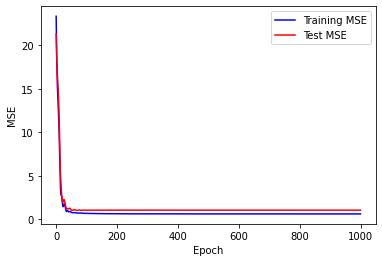

In [ ]:
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.plot(X,Y, c="blue", label="Training MSE")
plt.plot(X,Y_test, c="red", label="Test MSE")

plt.legend()
plt.show()

epoch: 0, cost: 13.394744873046875
epoch: 100, cost: 0.6388673186302185
epoch: 200, cost: 0.6084514856338501
epoch: 300, cost: 0.6043962240219116
epoch: 400, cost: 0.6036228537559509
epoch: 500, cost: 0.603183925151825
epoch: 600, cost: 0.6028608083724976
epoch: 700, cost: 0.602627158164978
epoch: 800, cost: 0.6024531722068787
epoch: 900, cost: 0.6023067831993103
epoch: 1000, cost: 0.6021876335144043


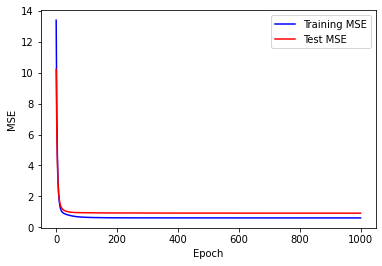

In [ ]:
#Bias 추가하기

lambda1 = 0.0001
lambda2 = 0.0001

lambda3 = 0.001
lambda4 = 0.001

P = torch.randn(numItems,rank,requires_grad=True) #아이템 매트릭스
Q = torch.randn(numUsers,rank,requires_grad=True) #사용자 매트릭스

bias_item = torch.randn(numItems, requires_grad=True)
bias_user = torch.randn(numUsers, requires_grad=True)
mean = (ratings.sum() / len(ratings)).item()

optimizer = torch.optim.Adam([P,Q, bias_item, bias_user], lr=0.1)

X = []
Y = []
Y_test = []

for epoch in range(1001):
  hypothesis = torch.sum(P[items] * Q[users], dim=1) + mean + bias_item[items] + bias_user[users]
  cost = F.mse_loss(hypothesis, ratings)
  loss = cost + lambda1 * torch.sum(P ** 2) + lambda2 * torch.sum(Q ** 2) \
        + lambda3 * torch.sum(bias_item ** 2) + lambda4 * torch.sum(bias_user ** 2)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  with torch.no_grad():
    X.append(epoch)
    Y.append(cost.item())

    hypo_test = (P[items_test] * Q[users_test]).sum(dim=1) \
    + mean + bias_item[items_test] + bias_user[users_test]
    cost_test = F.mse_loss(hypo_test,ratings_test)
    
    Y_test.append(cost_test)

    if epoch % 100 == 0:
      print(f"epoch: {epoch}, cost: {cost.item()}")

plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.plot(X,Y, c="blue", label="Training MSE")
plt.plot(X,Y_test, c="red", label="Test MSE")
plt.legend()
plt.show()